In [11]:
%reload_ext autoreload
%autoreload 2

In [12]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
from sklearn import svm


import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud
# !pip install gensim
# !conda install -y -c conda-forge gensim
# !pip install pyLDAvis
# !pip install nltk

# !conda install -y -c conda-forge pyldavis
# !pip install textblob
# !pip install mlflow



# import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import LdaModel
from gensim.corpora import Dictionary

from textblob import TextBlob
import matplotlib.pyplot as plt
import mlflow

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from textblob import TextBlob

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from gensim.corpora import Dictionary
from gensim.models import LdaModel


[nltk_data] Downloading package stopwords to /home/micky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/micky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/micky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('../../week0_network_analysis_project/')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

project_root = os.path.abspath('../../week0_network_analysis_project/src/')
sys.path.insert(0, project_root)

from helper.postgres_database_handler import PostgreSQLHandler
from helper.mongodb_database_handler import SlackMessageWithSchema


slack_db = SlackMessageWithSchema(database_name="week0_network_analysis")
db_handler = PostgreSQLHandler(dbname='week0_network_analysis', user='postgres', password='P@ss1234')


collection slack_messages already exists


### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [14]:
# # combine all json file in all-weeks8-9
# def slack_parser(path_channel):
#     """ parse slack data to extract useful informations from the json file
#         step of execution
#         1. Import the required modules
#         2. read all json file from the provided path
#         3. combine all json files in the provided path
#         4. extract all required informations from the slack data
#         5. convert to dataframe and merge all
#         6. reset the index and return dataframe
#     """

#     # specify path to get json files
#     combined = []
#     for json_file in glob.glob(f"{path_channel}*.json"):
#         with open(json_file, 'r', encoding="utf8") as slack_data:
#             combined.append(slack_data)

#     # loop through all json files and extract required informations
#     dflist = []
#     for slack_data in combined:

#         msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
#         reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

#         for row in slack_data:
#             if 'bot_id' in row.keys():
#                 continue
#             else:
#                 msg_type.append(row['type'])
#                 msg_content.append(row['text'])
#                 if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
#                 else: sender_id.append('Not provided')
#                 time_msg.append(row['ts'])
#                 if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
#                      msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
#                 else: msg_dist.append('reshared')
#                 if 'thread_ts' in row.keys():
#                     time_thread_st.append(row['thread_ts'])
#                 else:
#                     time_thread_st.append(0)
#                 if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
#                 else:    reply_users.append(0)
#                 if 'reply_count' in row.keys():
#                     reply_count.append(row['reply_count'])
#                     reply_users_count.append(row['reply_users_count'])
#                     tm_thread_end.append(row['latest_reply'])
#                 else:
#                     reply_count.append(0)
#                     reply_users_count.append(0)
#                     tm_thread_end.append(0)
#         data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
#          reply_count, reply_users_count, reply_users, tm_thread_end)
#         columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
#          'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

#         df = pd.DataFrame(data=data, columns=columns)
#         df = df[df['sender_name'] != 'Not provided']
#         dflist.append(df)

#     dfall = pd.concat(dflist, ignore_index=True)
#     dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
#     dfall = dfall.reset_index(drop=True)
    
#     return dfall


# def parse_slack_reaction(path, channel):
#     """get reactions"""
#     dfall_reaction = pd.DataFrame()
#     combined = []
#     for json_file in glob.glob(f"{path}*.json"):
#         with open(json_file, 'r') as slack_data:
#             combined.append(slack_data)

#     reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

#     for k in combined:
#         slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
#         for i_count, i in enumerate(slack_data):
#             if 'reactions' in i.keys():
#                 for j in range(len(i['reactions'])):
#                     msg.append(i['text'])
#                     user_id.append(i['user'])
#                     reaction_name.append(i['reactions'][j]['name'])
#                     reaction_count.append(i['reactions'][j]['count'])
#                     reaction_users.append(",".join(i['reactions'][j]['users']))
                
#     data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
#     columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
#     df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
#     df_reaction['channel'] = channel
#     return df_reaction

# def get_community_participation(path):
#     """ specify path to get json files"""
#     combined = []
#     comm_dict = {}
#     for json_file in glob.glob(f"{path}*.json"):
#         with open(json_file, 'r') as slack_data:
#             combined.append(slack_data)
#     # print(f"Total json files is {len(combined)}")
#     for i in combined:
#         a = json.load(open(i.name, 'r', encoding='utf-8'))

#         for msg in a:
#             if 'replies' in msg.keys():
#                 for i in msg['replies']:
#                     comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
#     return comm_dict

In [15]:
# def convert_2_timestamp(column, data):
#     """convert from unix time to readable timestamp
#         args: column: columns that needs to be converted to timestamp
#                 data: data that has the specified column
#     """
#     if column in data.columns.values:
#         timestamp_ = []
#         for time_unix in data[column]:
#             if time_unix == 0:
#                 timestamp_.append(0)
#             else:
#                 a = datetime.datetime.fromtimestamp(float(time_unix))
#                 timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
#         return timestamp_
#     else: 
#         print(f"{column} not in data")

# def get_tagged_users(df):
#     """get all @ in the messages"""

#     return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
# def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
#     """
#     map slack_id to realnames
#     user_profile: a dictionary that contains users info such as real_names
#     comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
#     """
#     user_dict = {} # to store the id
#     real_name = [] # to store the real name
#     ac_comm_dict = {} # to store the mapping
#     count = 0
#     # collect all the real names
#     for i in range(len(user_profile['profile'])):
#         real_name.append(dict(user_profile['profile'])[i]['real_name'])

#     # loop the slack ids
#     for i in user_profile['id']:
#         user_dict[i] = real_name[count]
#         count += 1

#     # to store mapping
#     for i in comm_dict:
#         if i in user_dict:
#             ac_comm_dict[user_dict[i]] = comm_dict[i]

#     ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
#     columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
#     if plot:
#         ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
#         plt.title('Student based on Message sent in thread', size=20)
        
#     return ac_comm_dict

In [16]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

### Minimum Essential To Do: Task 1

In [17]:
# Who are the top and bottom 10  users by:
    # Reaction count?

import pandas as pd
from functools import reduce

data_path = os.path.join(rpath, "data/anonymized")
data_loader = SlackDataLoader(data_path)
directories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
channel_name = 'all-week8'

dataframe_by_directory = [
    data_loader.parse_slack_reaction(os.path.join(data_path, directory), channel_name).assign(directory=directory)
    for directory in directories
]

# Concatenate all DataFrames into a single DataFrame
df_combined = reduce(lambda df1, df2: pd.concat([df1, df2], ignore_index=True), dataframe_by_directory)


reaction_df = pd.concat(dataframe_by_directory, ignore_index=True)

users_df= pd.DataFrame(data_loader.get_users())
users_df.rename(columns={'id':'user_id'}, inplace = True)

reactions_merged = pd.merge(reaction_df, users_df, on='user_id', how='outer')


top_10_reactions = reactions_merged.groupby('real_name')['reaction_count'].sum().reset_index(name='total_reaction_count').sort_values(by='total_reaction_count', ascending=False).head(10)

bottom_10_reactions = reactions_merged.groupby('real_name')['reaction_count'].sum().reset_index(name='total_reaction_count').sort_values(by='total_reaction_count', ascending=True).head(10)

relevant_user_columns = ['user_id', 'real_name', 'reaction_count', 'reaction_users_count', 'message', 'channel']

slack_db.insert_many_to_collection('reactions', reactions_merged[relevant_user_columns].to_dict(orient='records'))
print("Data inserted into the collection.")


Data inserted into the collection.


In [18]:
# Who are the top and bottom 10  users by:
        # Reply count? 
        # Mention? 
        # Message count? 

data_path = os.path.join(rpath, "data/anonymized")
data_loader = SlackDataLoader(data_path)
folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

dataframes_by_folder = [data_loader.slack_parser(os.path.join(data_path, folder)).assign(folder=folder) for folder in folders]

parsed_data = pd.concat(dataframes_by_folder, ignore_index=True)
parsed_data.head(5)

reply_count_by_message = parsed_data.groupby('msg_content')['reply_count'].sum().reset_index(name='Reply count')
# print(reply_count_by_message)

message_count_by_user = parsed_data.groupby('sender_name').size().reset_index(name='Message count')

mention_count_by_user = parsed_data['msg_content'].str.count('@\w+').groupby(parsed_data['sender_name']).sum().reset_index(name='Mention count')

reply_count_by_user = parsed_data.groupby('sender_name')['reply_count'].sum().reset_index(name='Reply count')

user_stats = pd.merge(message_count_by_user, mention_count_by_user, on='sender_name', how='outer')
user_stats = pd.merge(user_stats, reply_count_by_user, on='sender_name', how='outer')

user_stats = user_stats.fillna(0)

user_stats['Total count'] = user_stats['Message count'] + user_stats['Mention count'] + user_stats['Reply count']

# slack_db.insert_many_to_collection(colleciton, user_stats)

top_10_reply = user_stats.sort_values(by='Reply count', ascending=False).head(10)
bottom_10_reply = user_stats.sort_values(by='Reply count', ascending=True).head(10)

top_10_mention = user_stats.sort_values(by='Mention count', ascending=False).head(10)
bottom_10_mention = user_stats.sort_values(by='Mention count', ascending=True).head(10)

top_10_message = user_stats.sort_values(by='Message count', ascending=False).head(10)
bottom_10_message = user_stats.sort_values(by='Message count', ascending=True).head(10)

# print("Top 10 Users by Reply Count:")
# print(top_10_reply[['sender_name', 'Reply count']])

# print("\nBottom 10 Users by Reply Count:")
# print(bottom_10_reply[['sender_name', 'Reply count']])

# print("\nTop 10 Users by Mention Count:")
# print(top_10_mention[['sender_name', 'Mention count']])

# print("\nBottom 10 Users by Mention Count:")
# print(bottom_10_mention[['sender_name', 'Mention count']])

# print("\nTop 10 Users by Message Count:")
# print(top_10_message[['sender_name', 'Message count']])

# print("\nBottom 10 Users by Message Count:")
# print(bottom_10_message[['sender_name', 'Message count']])

# sorted_user_stats = user_stats.sort_values(by='Reply count', ascending=False)

# if not sorted_user_stats.empty:
#     # Convert NaN values to None for compatibility with MongoDB
#     sorted_user_stats = sorted_user_stats.where(pd.notna(sorted_user_stats), None)

#     # Print and insert into the 'replies' collection
#     print("Top 10 Users by Reply Count:")
#     print(sorted_user_stats.head(10)[['sender_name', 'Reply count']])

#     print("\nBottom 10 Users by Reply Count:")
#     print(sorted_user_stats.tail(10)[['sender_name', 'Reply count']])

selected_columns = ['sender_name', 'Message count', 'Mention count', 'Reply count', 'Total count']

# Sort the DataFrame and select relevant columns
selected_data = user_stats[selected_columns].head(5)
print(f"Shape: {selected_data.shape}")

# print(f"Selected :{selected_data.head(10)}")
# Convert NaN values to None for compatibility with MongoDB
# selected_data = selected_data.where(pd.notna(selected_data), None)

# Insert into the 'replies' collection
# slack_db.insert_many_to_collection('replies', selected_data)

if not user_stats.empty:
    slack_db.insert_many_to_collection('replies', selected_data.sort_values(by='Reply count', ascending=False).to_dict(orient='records'))
    print("Data inserted successfully.")
else:
    print("DataFrame is empty. No data inserted.")

<>:20: DeprecationWarning: invalid escape sequence '\w'
<>:20: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipykernel_13505/753755905.py:20: DeprecationWarning: invalid escape sequence '\w'
  mention_count_by_user = parsed_data['msg_content'].str.count('@\w+').groupby(parsed_data['sender_name']).sum().reset_index(name='Mention count')


Shape: (5, 5)
Data inserted successfully.


In [36]:
#What are the top 10 messages by 
    # Replies?
    # Reactions?
    # Mentions?
data_path = os.path.join(rpath, "data/anonymized")
data_loader = SlackDataLoader(data_path)
folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

dataframes_by_folder = [data_loader.slack_parser(os.path.join(data_path, folder)).assign(folder=folder) for folder in folders]

parsed_data = pd.concat(dataframes_by_folder, ignore_index=True)
parsed_data.head(5)
parsed_data.shape

parsed_data['time_thread_start'] = parsed_data['time_thread_start'].astype(str)
parsed_data['tm_thread_end'] = parsed_data['tm_thread_end'].astype(str)

if not parsed_data.empty:
    slack_db.insert_many_to_collection('slack_messages', parsed_data.to_dict(orient='records'))
    print("Data inserted successfully.")
else:
    print("DataFrame is empty. No data inserted.")

reply_count_by_message = parsed_data.groupby('msg_content')['reply_count'].sum().reset_index(name='Reply count')

reaction_count_by_message = parsed_data.groupby('msg_content')['reply_users_count'].sum().reset_index(name='Reaction count')

mention_count_by_message = parsed_data['msg_content'].str.count('@\w+').groupby(parsed_data['msg_content']).sum().reset_index(name='Mention count')

message_stats = pd.merge(reply_count_by_message, reaction_count_by_message, on='msg_content', how='outer')
message_stats = pd.merge(message_stats, mention_count_by_message, on='msg_content', how='outer')

message_stats = message_stats.fillna(0)

message_stats['Total count'] = message_stats['Reply count'] + message_stats['Reaction count'] + message_stats['Mention count']

top_10_reply_message = message_stats.sort_values(by='Reply count', ascending=False).head(10)
top_10_reaction_message = message_stats.sort_values(by='Reaction count', ascending=False).head(10)
top_10_mention_message = message_stats.sort_values(by='Mention count', ascending=False).head(10)

print("\nTop 10 Messages by Reply Count:")
print(top_10_reply_message[['msg_content', 'Reply count']])

print("\nTop 10 Messages by Reaction Count:")
print(top_10_reaction_message[['msg_content', 'Reaction count']])

print("\nTop 10 Messages by Mention Count:")
print(top_10_mention_message[['msg_content', 'Mention count']])



Data inserted successfully.


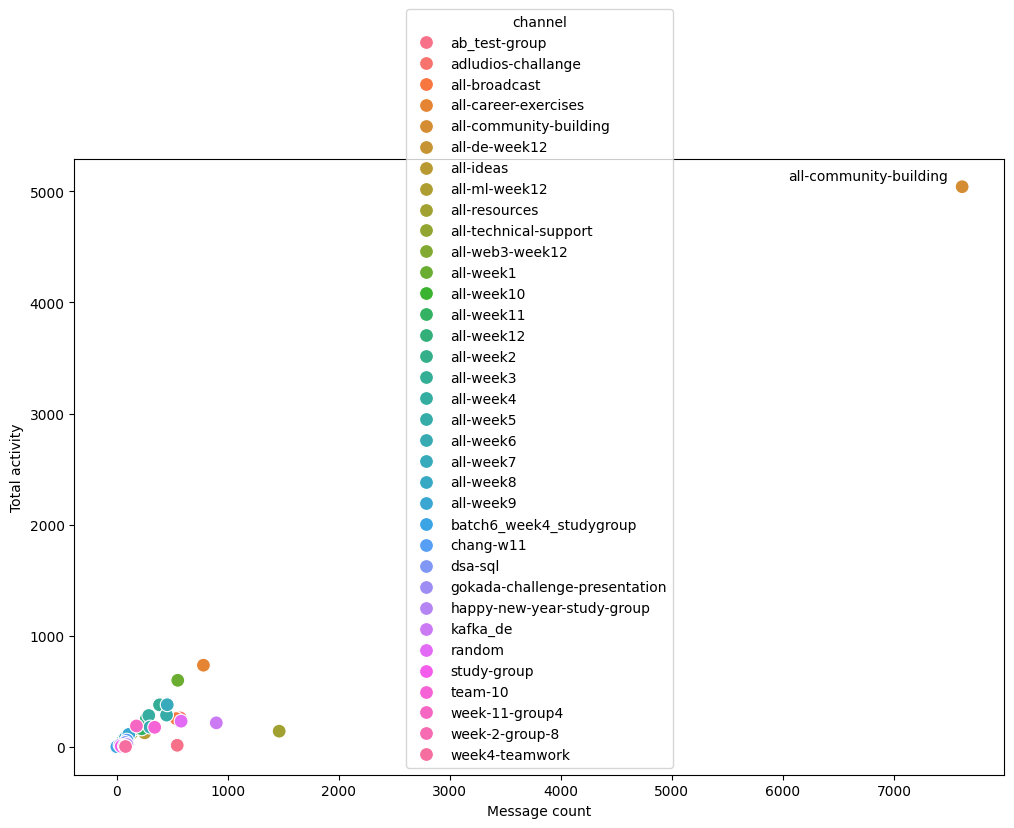

The channel with the highest activity is: all-community-building


In [21]:
# Which channel has the highest activity? 
# Which channel appears at the right top corner when you plot a 2D scatter plot where x-axis is the number of messages in the channel,
# y-axis is the sum of number of replies and reactions, and the color representing channels?



import matplotlib.pyplot as plt
import seaborn as sns

data_path = os.path.join(rpath, "data/anonymized")
data_loader = SlackDataLoader(data_path)
folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

dataframes_by_folder = [data_loader.slack_parser(os.path.join(data_path, folder)).assign(folder=folder) for folder in folders]

parsed_data = pd.concat(dataframes_by_folder, ignore_index=True)
parsed_data.head(5)

message_count_by_channel = parsed_data.groupby('channel')['msg_content'].count().reset_index(name='Message count')
activity_by_channel = parsed_data.groupby('channel')[['reply_count', 'reply_users_count']].sum().reset_index()
activity_by_channel['Total activity'] = activity_by_channel['reply_count'] + activity_by_channel['reply_users_count']
channel_stats = pd.merge(message_count_by_channel, activity_by_channel, on='channel', how='outer')
channel_stats = channel_stats.fillna(0)

plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='Message count', y='Total activity', hue='channel', data=channel_stats, s=100)
right_top_channel = channel_stats.loc[channel_stats['Total activity'].idxmax()]
scatter_plot.annotate(right_top_channel['channel'], 
                      (right_top_channel['Message count'], right_top_channel['Total activity']),
                      textcoords="offset points", 
                      xytext=(-10, 5),
                      ha='right')
plt.show()

most_active_channel = channel_stats.loc[channel_stats['Total activity'].idxmax()]
print(f"The channel with the highest activity is: {most_active_channel['channel']}")



Scatter        time_diff_first_reply time_of_day    channel
0              -2.771760e+07       08:00  all-week4
1              -2.771760e+07       08:02  all-week4
2               0.000000e+00       08:14  all-week4
3              -1.212487e+00       08:15  all-week4
4              -2.812628e+00       08:17  all-week4
...                      ...         ...        ...
17744          -2.772759e+07       06:26  all-week5
17745           0.000000e+00       06:28  all-week5
17746          -3.898415e+00       06:32  all-week5
17747          -1.682394e+01       06:44  all-week5
17748          -2.995420e+01       06:58  all-week5

[17749 rows x 3 columns]


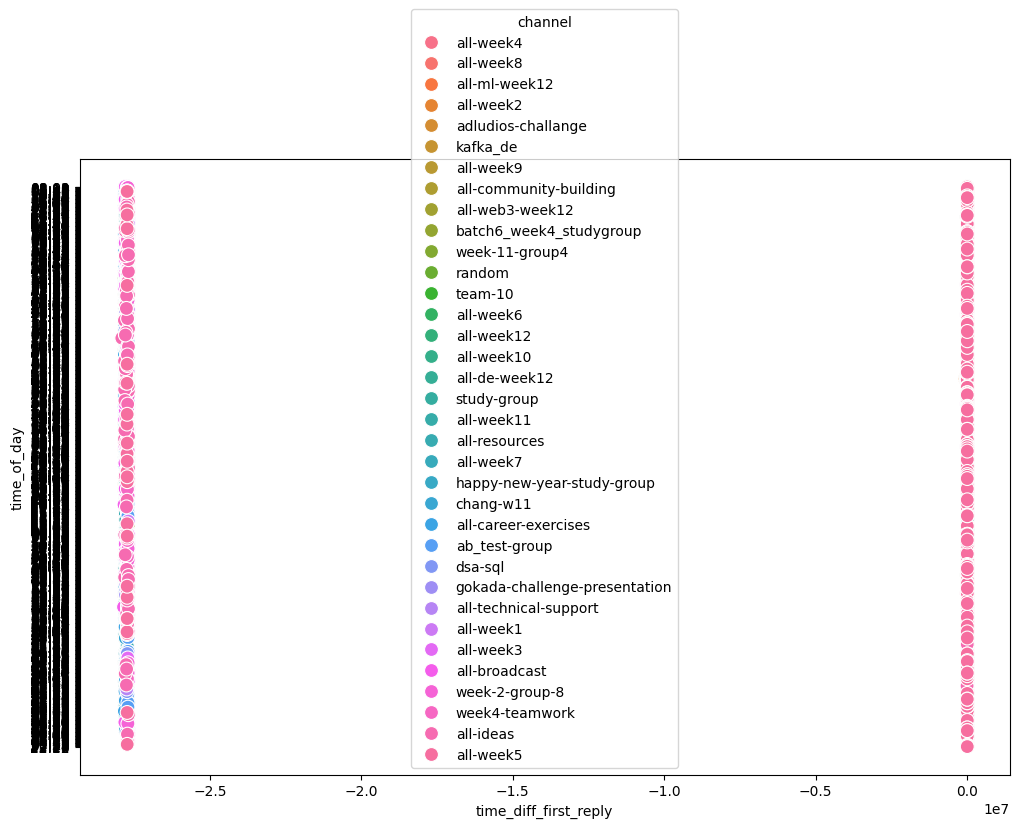

In [22]:
# What fraction of messages are replied within the first 5mins?
# Plot a 2D scatter plot such that x-axis is the time difference between the message timestamp and the first reply message, 
# y-axis is the time of the day (in 24hr format), color representing channels? 


import matplotlib.pyplot as plt
import seaborn as sns

data_path = os.path.join(rpath, "data/anonymized")
data_loader = SlackDataLoader(data_path)
folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

dataframes_by_folder = [data_loader.slack_parser(os.path.join(data_path, folder)).assign(folder=folder) for folder in folders]

parsed_data = pd.concat(dataframes_by_folder, ignore_index=True)
parsed_data.head(5)
# slack_parser_df.head(5)

parsed_data['time_thread_start'] = pd.to_numeric(parsed_data['time_thread_start'], errors='coerce')
parsed_data['msg_sent_time'] = pd.to_numeric(parsed_data['msg_sent_time'], errors='coerce')

parsed_data['time_diff_first_reply'] = (parsed_data['time_thread_start'] - parsed_data['msg_sent_time']) / 60

parsed_data['time_of_day'] = pd.to_datetime(parsed_data['msg_sent_time'], unit='s').dt.strftime('%H:%M')

scatter_data = parsed_data[['time_diff_first_reply', 'time_of_day', 'channel']]
print(f"Scatter {scatter_data}")
# Plot a 2D scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(x='time_diff_first_reply', y='time_of_day', hue='channel', data=scatter_data, s=100)

# Display the plot
plt.show()

### Minimum Essential To Do: Task 2

In [23]:
# Test for slack_parser method
import unittest
test_path = os.path.join(rpath, "tests")

# Load the test suite
loader = unittest.TestLoader()
suite = loader.discover(test_path, pattern='test_*.py')

# Run the tests
runner = unittest.TextTestRunner()
result = runner.run(suite)

# Check the test result
result.wasSuccessful()

.
----------------------------------------------------------------------
Ran 1 test in 0.056s

OK


Empty DataFrame
Columns: [msg_type, msg_content, sender_name, msg_sent_time, msg_dist_type, time_thread_start, reply_count, reply_users_count, reply_users, tm_thread_end, channel]
Index: []


True

Parsed Replies:       msg_type                                        msg_content  \
17202  message  i am glad to make it to the week 1-4 program. ...   
17203  message                            thank you Joanneacademy   
17204  message               hello everyone! i'm glad to be here.   
17205  message  hello everyone wellcome to week 1- 4 tenx inte...   
17206  message                 hello guys. i'm happy to  be here.   

             sender_name       msg_sent_time msg_dist_type  time_thread_start  \
17202      Dennis Parker 2022-08-20 16:52:46          text                0.0   
17203  Jennifer Carrillo 2022-08-20 16:53:24          text                0.0   
17204   Catherine Campos 2022-08-20 16:57:21          text                0.0   
17205       Trevor Duffy 2022-08-20 17:05:03          text                0.0   
17206       Melanie Cole 2022-08-20 17:33:40          text                0.0   

       reply_count  reply_users_count reply_users tm_thread_end    channel  \
1720

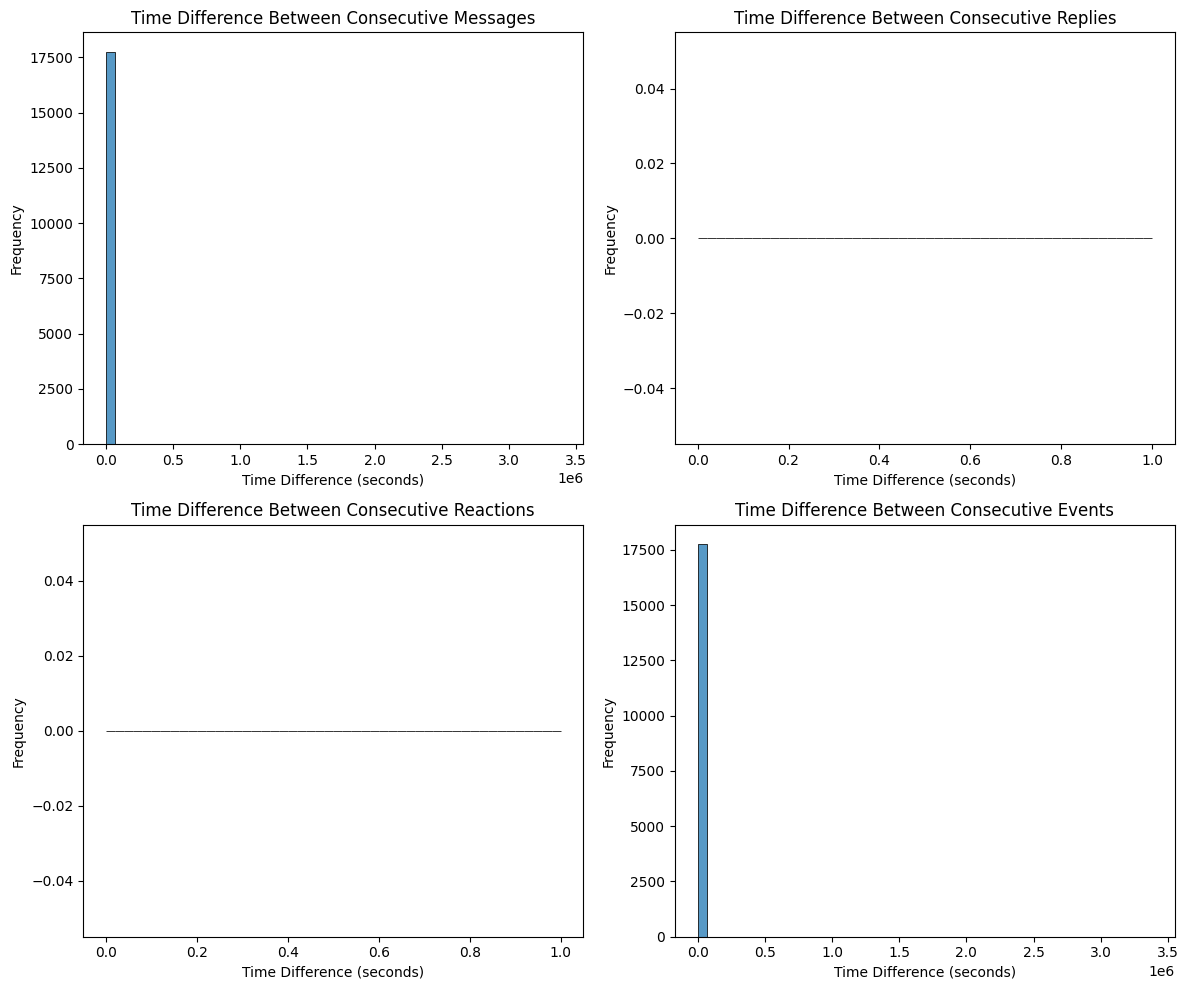

In [24]:
# Answer the following question 
# What is the distribution of time differences between messages, replies, reactions, and any type event (message, reply, reaction)?
# Plot a histogram of the time difference between 
# Consecutive messages 
# Consecutive replies 
# Consecutive reactions
# Consecutive events (message, reply, reaction)


parsed_data['msg_sent_time'] = utils.convert_2_timestamp('msg_sent_time', parsed_data)
parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'])

parsed_data = parsed_data.sort_values(by='msg_sent_time')

parsed_data['time_diff_messages'] = parsed_data['msg_sent_time'].diff()
parsed_data['time_diff_replies'] = parsed_data[parsed_data['msg_type'] == 'reply']['msg_sent_time'].diff()
print(f"Parsed Replies: {parsed_data.head(5)}")
parsed_data['time_diff_reactions'] = parsed_data[parsed_data['msg_type'] == 'reaction']['msg_sent_time'].diff()
parsed_data['time_diff_events'] = parsed_data['msg_sent_time'].diff()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Consecutive messages
sns.histplot(parsed_data['time_diff_messages'].dt.total_seconds(), bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Time Difference Between Consecutive Messages')
axes[0, 0].set_xlabel('Time Difference (seconds)')
axes[0, 0].set_ylabel('Frequency')

# Consecutive replies
sns.histplot(parsed_data['time_diff_replies'].dt.total_seconds(), bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Time Difference Between Consecutive Replies')
axes[0, 1].set_xlabel('Time Difference (seconds)')
axes[0, 1].set_ylabel('Frequency')

# Consecutive reactions
sns.histplot(parsed_data['time_diff_reactions'].dt.total_seconds(), bins=50, ax=axes[1, 0])
axes[1, 0].set_title('Time Difference Between Consecutive Reactions')
axes[1, 0].set_xlabel('Time Difference (seconds)')
axes[1, 0].set_ylabel('Frequency')

# Consecutive events
sns.histplot(parsed_data['time_diff_events'].dt.total_seconds(), bins=50, ax=axes[1, 1])
axes[1, 1].set_title('Time Difference Between Consecutive Events')
axes[1, 1].set_xlabel('Time Difference (seconds)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



In [25]:

data_path = os.path.join(rpath, "data/anonymized")
data_loader = SlackDataLoader(data_path)
folders = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

dataframes_by_folder = [data_loader.slack_parser(os.path.join(data_path, folder)).assign(folder=folder) for folder in folders]

parsed_data = pd.concat(dataframes_by_folder, ignore_index=True)
parsed_data.head(200)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,folder
0,message,join\n<https://meet.Stephanie.com/ysb-kjdn-hpp>,Catherine Campos,1663056028.465459,text,0,0,0,,0,all-week4,all-week4
1,message,join us for the standup <http://meet.Stephanie...,Bridget Glover,1663056132.923619,text,0,0,0,,0,all-week4,all-week4
2,message,"hello guys, yesterday i didn't attend the stan...",Trevor Duffy,1663056871.009349,text,1663056871.009349,3,3,"U03V61VGQG0,U03TEPYRM2P,U03UUMR26Q1",1663057089.283949,all-week4,all-week4
3,message,"me too bro, try to start from the challenge ov...",Diane Cruz,1663056943.758579,text,1663056871.009349,0,0,,0,all-week4,all-week4
4,message,<https://youtu.be/sqkzkhvr3be>,Bridget Glover,1663057039.767019,link,1663056871.009349,0,0,,0,all-week4,all-week4
...,...,...,...,...,...,...,...,...,...,...,...,...
195,message,"same here, we all feel overwhelmed, i personal...",Gregory Bowman,1663146566.049579,text,1663145743.087849,0,0,,0,all-week4,all-week4
196,message,i think you are right....\n1. read and researc...,Tammy Foster,1663146836.986529,text,1663145914.649449,0,0,,0,all-week4,all-week4
197,message,"also, the best thing i think you can add to th...",Gregory Bowman,1663146853.939789,text,1663145914.649449,0,0,,0,all-week4,all-week4
198,message,"thank you *fish,* i'm dealing with the overwhe...",Cynthia Davis,1663147546.049229,text,1663145743.087849,0,0,,0,all-week4,all-week4


In [26]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Apply the preprocessing to 'msg_content'
parsed_data['preprocessed_text'] = parsed_data['msg_content'].apply(preprocess_text)

# Create dictionary and corpus
dictionary = Dictionary(parsed_data['preprocessed_text'])
corpus = [dictionary.doc2bow(text) for text in parsed_data['preprocessed_text']]

print(f"Message Content after preprocessing: {parsed_data['preprocessed_text']}")
print(" ")
print("Printing Dictionary")
print(dictionary)
print(corpus)

Message Content after preprocessing: 0                                             [join, http]
1                                 [join, u, standup, http]
2        [hello, guy, yesterday, attend, standup, tutor...
3        [bro, try, start, challenge, overview, http, a...
4                                                   [http]
                               ...                        
17744                                 [hey, good, morning]
17745    [anyone, trouble, getting, data, pneuma, cause...
17746                                               [yeah]
17747                                                   []
17748                                                   []
Name: preprocessed_text, Length: 17749, dtype: object
 
Printing Dictionary
Dictionary<8125 unique tokens: ['http', 'join', 'standup', 'u', 'anyone']...>
[[(0, 1), (1, 1)], [(0, 1), (1, 1), (2, 1), (3, 1)], [(2, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2)], [(0,

In [27]:
# lda
number_of_topics = 5
lda_model = LdaModel(corpus=corpus, num_topics=number_of_topics, id2word=dictionary, passes=15, random_state=42)

# Print topics and associated words
topics = lda_model.print_topics(num_words=10)
# for topic in topics:
#     print(topic)


print(lda_model.show_topics(formatted=False))

[(0, [('yeah', 0.017252747), ('install', 0.013874353), ('wa', 0.013753486), ('high', 0.012079666), ('low', 0.011062492), ('got', 0.009565554), ('email', 0.008186634), ('test', 0.008063489), ('dbt', 0.0076003433), ('store', 0.006791586)]), (1, [('wa', 0.01766821), ('file', 0.013871816), ('use', 0.012907645), ('thank', 0.012532755), ('error', 0.012266095), ('data', 0.012183384), ('working', 0.010920442), ('group', 0.009947611), ('using', 0.009672678), ('gt', 0.009276436)]), (2, [('think', 0.018798137), ('try', 0.014688571), ('data', 0.0140726315), ('sure', 0.011147006), ('task', 0.010501484), ('get', 0.010238595), ('help', 0.009660599), ('could', 0.009337909), ('make', 0.009194935), ('let', 0.009037545)]), (3, [('http', 0.1649568), ('link', 0.023838779), ('amp', 0.019975832), ('one', 0.013175169), ('joy', 0.012240668), ('joanne', 0.011934872), ('okay', 0.009134505), ('great', 0.0091225235), ('like', 0.009063825), ('day', 0.00904898)]), (4, [('session', 0.036427606), ('time', 0.035830613)

In [28]:
#  Sentiment analysis

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis_data)


/tmp/ipykernel_13505/1093366182.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'], unit='s')


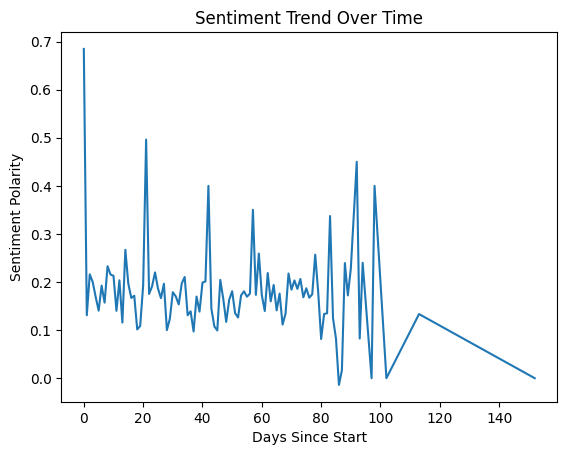

In [29]:
# Step 1: Group messages by day since the start of the training
parsed_data['msg_sent_time'] = pd.to_datetime(parsed_data['msg_sent_time'], unit='s')
parsed_data['day_since_start'] = (parsed_data['msg_sent_time'] - parsed_data['msg_sent_time'].min()).dt.days
grouped_by_day = parsed_data.groupby('day_since_start')

# Step 2: Concatenate messages for each day
aggregated_messages = grouped_by_day['msg_content'].apply(lambda x: ' '.join(x)).reset_index()

# Step 3: Perform sentiment analysis
aggregated_messages['sentiment'] = aggregated_messages['msg_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Step 4: Analyze the time series trend of sentiments
plt.plot(aggregated_messages['day_since_start'], aggregated_messages['sentiment'])
plt.xlabel('Days Since Start')
plt.ylabel('Sentiment Polarity')
plt.title('Sentiment Trend Over Time')
plt.show()

In [30]:

# Not finished

artifacts_dir = os.path.join(rpath, "artifacts")
if not os.path.exists(artifacts_dir):
    os.makedirs(artifacts_dir)

# Start MLflow run
with mlflow.start_run() as run:
    # Log hyperparameters
    number_of_topics = 5
    mlflow.log_param("num_topics", number_of_topics)
    mlflow.log_param("passes", 15)
    mlflow.log_param("random_state", 42)

    # Train LDA model
    lda_model = LdaModel(corpus=corpus, num_topics=number_of_topics, id2word=dictionary, passes=15, random_state=42)

    # Log the LDA model
    mlflow.sklearn.log_model(lda_model, "lda_model")

    # Save artifacts (dictionary and corpus)
    mlflow.log_artifact("artifacts/dictionary.pkl", "artifacts")
    mlflow.log_artifact("artifacts/corpus.pkl", "artifacts")

# Retrieve the run_id
run_id = run.info.run_id
print("Run ID:", run_id)


2023/12/01 20:14:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/home/micky/miniconda3/lib/python3.11/importlib/__init__.py:126: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  return _bootstrap._gcd_import(name[level:], package, level)


FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/dictionary.pkl'